# GE Discovery MI (Listmode Reconstruction; With Time of Flight)

This tutorial demonstrates how to use PyTomography's algorithm for VOI based uncertainty estimation in PET reconstruction. The first part of the tutorial is the same as the introductory PET reconstruction tutorial for the discovery MI data. The data here can be downloaded from https://zenodo.org/records/8404015

In [1]:
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, BSREM
from pytomography.priors import RelativeDifferencePrior
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.io.PET import clinical
import torch
import itk
import numpy as np
from pytomography.callbacks import DataStorageCallback

This code is from the introductory PET tutorial for discovery MI data

In [2]:
scanner_name = 'discovery_MI'
info = clinical.get_detector_info(scanner_name)

# Get listmode events
detector_ids = clinical.get_detector_ids_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/LIST0000.BLF', scanner_name)
# Get scatter/random correction term at each event
additive_term = clinical.get_additive_term_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/corrections.h5')
# Get multiplicative weights (attenuation/normalization) at each event
weights = clinical.get_weights_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/corrections.h5')
# Get ALL valid detector-pairs and corresponding multiplicative weights
detector_ids_sensitivity, weights_sensitivity = clinical.get_sensitivity_ids_and_weights_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/corrections.h5', scanner_name)

# Define object space reconstruction matrix
object_meta = ObjectMeta(
    dr=(2.78,2.78,2.78), #mm
    shape=(192,192,71) #voxels
)
# Get time-of-flight metadata and define projection space metadata
tof_meta = clinical.get_tof_meta(scanner_name)
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    tof_meta=tof_meta,
    detector_ids_sensitivity=detector_ids_sensitivity,
    weights_sensitivity=weights_sensitivity
    )

psf_transform = GaussianFilter(4.5) # 4.5mm gaussian psf
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    N_splits=8,
)
likelihood = PoissonLogLikelihood(
    system_matrix,
    additive_term=additive_term/weights,
)

For uncertainty estimation, we to create a `DataStorageCallback` instance to store the reconstructed image for every iteration of reconstruction

In [3]:
recon_algorithm = OSEM(likelihood)
data_storage_callback = DataStorageCallback(likelihood, torch.clone(recon_algorithm.object_prediction))
recon_OSEM = recon_algorithm(n_iters=2, n_subsets=34, callback=data_storage_callback)

We can plot the reconstructed image:

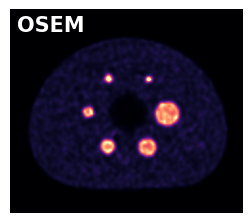

In [4]:
fig, ax = plt.subplots(1,1,figsize=(3,3))   
plt.sca(ax)
plt.imshow(recon_OSEM[:,:,20].T.cpu(), cmap='magma', interpolation='gaussian', vmax=0.5)
plt.axis('off')
plt.text(0.03, 0.97, 'OSEM', color='white', fontsize=15, fontweight='bold', transform=plt.gca().transAxes, ha='left', va='top')
plt.xlim(35,157)
plt.ylim(45,152)
plt.show()

Lets load masks of each of the NEMA spheres:

In [5]:
mask = np.transpose(itk.GetArrayFromImage(itk.imread('/disk1/uncertainty_spect/fdg_scan/fdg_spheres.seg.nrrd')), (2,1,0))
masks = [torch.tensor(mask==i).to(torch.float32).to(pytomography.device) for i in range(1,9)]

We can estimate the uncertainty on the largest sphere, corresponding to the first mask:

In [6]:
uncertainty_abs, uncertainty_pct = recon_algorithm.compute_uncertainty(
    mask = masks[0],
    data_storage_callback = data_storage_callback,
    return_pct = True,
)

In [7]:
print(f'Estimated uncertainty in large sphere: {uncertainty_pct:.2f}%')

Estimated uncertainty in large sphere: 1.63%
